In [1]:
#!pip install trimesh
!python --version

Python 3.12.10


In [2]:
## Code adapted from
## https://www.youtube.com/watch?v=GGxpqfTvE8c

In [3]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [4]:
# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  0


In [5]:
# Download the Dataset
#DATA_DIR = tf.keras.utils.get_file(
#    "modelnet.zip",
#    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
#    extract=True,
#)
#DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [6]:
# Copied data into folder, so changed path
#DATA_DIR = 'ModelNet10/'
DATA_DIR = "data/"

In [7]:
# Function to parse data
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    
    #folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    folders = sorted(
        os.path.join(DATA_DIR, d) for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))
    )
    #print(folders)

    for i, folder in enumerate(folders):
        print("Processing class: {}".format(os.path.basename(folder)))
        # Store foldername with ID for later retrieval
        class_map[i] = folder.split("/")[-1]
        # Gather all files
        #train_files = glob.glob(os.path.join(folder, "train/*"))
        train_files = glob.glob(os.path.join(folder, "train", "*.obj"))
        #test_files = glob.glob(os.path.join(folder, "test/*"))
        test_files = glob.glob(os.path.join(folder, "test", "*.obj"))
        
        for f in train_files:
            mesh = trimesh.load(f, force="mesh")
            mesh.apply_translation(-mesh.centroid)
            mesh.apply_scale(1.0 / mesh.scale)
            train_points.append(mesh.sample(num_points))
            #train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            mesh = trimesh.load(f, force="mesh")
            mesh.apply_translation(-mesh.centroid)
            mesh.apply_scale(1.0 / mesh.scale)
            test_points.append(mesh.sample(num_points))
            #test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [8]:
# Parse dataset and process each class
NUM_POINTS = 2048
NUM_CLASSES = 2   #2,10
BATCH_SIZE = 32

In [9]:
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

Processing class: GazellaSubgutturosa
Processing class: OvisAries


In [10]:
# Augmentation for Train Dataset
def random_rotation_so3(points):
    # random unit quaternion -> rotation matrix
    u1 = tf.random.uniform([], 0, 1)
    u2 = tf.random.uniform([], 0, 1)
    u3 = tf.random.uniform([], 0, 1)
    q1 = tf.sqrt(1-u1) * tf.sin(2*np.pi*u2)
    q2 = tf.sqrt(1-u1) * tf.cos(2*np.pi*u2)
    q3 = tf.sqrt(u1)   * tf.sin(2*np.pi*u3)
    q4 = tf.sqrt(u1)   * tf.cos(2*np.pi*u3)

    # quaternion (x,y,z,w) -> rotation matrix
    x,y,z,w = q1,q2,q3,q4
    R = tf.stack([
        [1-2*(y*y+z*z),   2*(x*y - z*w), 2*(x*z + y*w)],
        [2*(x*y + z*w), 1-2*(x*x+z*z),   2*(y*z - x*w)],
        [2*(x*z - y*w),   2*(y*z + x*w), 1-2*(x*x+y*y)]
    ], axis=0)
    return tf.linalg.matmul(points, R)

def augment(points, label):
    points = tf.cast(points, tf.float32)
    # check for rotations
    points = random_rotation_so3(points)
    # jitter points
    points += tf.random.uniform(tf.shape(points), -0.005, 0.005, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [11]:
# Functions to buildthe model
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    return layers.Activation("relu")(x)

In [12]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, coef=1e-4):
        self.num_features = num_features
        self.coef = coef

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.matmul(x, x, transpose_b=True)
        I = tf.eye(self.num_features, batch_shape=[tf.shape(x)[0]])
        diff = xxt - I
        return self.coef * tf.reduce_mean(tf.square(diff))

In [13]:
# Function to create T-net layers
def tnet(inputs, num_features):
    # initialize bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    #Apply affine transformation to input features
    return layers.Dot(axes=(2,1))([inputs, feat_T])

In [14]:
# Create the Convolutional Neural Network
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 2048, 3)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 2048, 32)          │             128 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 2048, 32)          │             128 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 2048, 32)          │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 2048, 64)          │           2,112 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 2048, 64)          │             256 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 2048, 64)          │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 2048, 512)         │          33,280 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 2048, 512)         │           2,048 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 2048, 512)         │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 512)               │               0 │ activation_2[0][0]         │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         131,328 │ global_max_pooling1d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 256)               │           1,024 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 256)               │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,89

 Total params: 747,947 (2.85 MB)

 Trainable params: 741,867 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [15]:
#counts = np.bincount(train_labels)
#class_weight = {i: (len(train_labels) / (len(counts)*c)) for i, c in enumerate(counts)}
#print("class_weight:", class_weight)

# Compile and train model
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_sparse_categorical_accuracy",
        mode="max",
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=4,
        min_lr=1e-6
    ),
]

# Conter the imbalance of the training set to improve classification
ds = tf.data.Dataset.from_tensor_slices((train_points, train_labels))

ds0 = ds.filter(lambda x,y: tf.equal(y, 0)).repeat()
ds1 = ds.filter(lambda x,y: tf.equal(y, 1)).repeat()

train_dataset = tf.data.Dataset.sample_from_datasets([ds0, ds1], weights=[0.5, 0.5])
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = max(10, len(train_points) // BATCH_SIZE)

model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 0.8575 - sparse_categorical_accuracy: 0.5437 - val_loss: 1.1658 - val_sparse_categorical_accuracy: 0.4118 - learning_rate: 3.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.8161 - sparse_categorical_accuracy: 0.5469 - val_loss: 0.8353 - val_sparse_categorical_accuracy: 0.4118 - learning_rate: 3.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.7591 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.6680 - val_sparse_categorical_accuracy: 0.7059 - learning_rate: 3.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.7516 - sparse_categorical_accuracy: 0.5969 - val_loss: 2.2763 - val_sparse_categorical_accuracy: 0.4118 - learning_rate: 3.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.6560 - sparse_categorical_accuracy: 0.6625 - val_loss: 2.4910 - val_sparse_categorical_accuracy: 0.4118 - learning_rate: 3.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━

In [16]:
#xb, yb = next(iter(train_dataset.take(1)))
#pred = model(xb, training=False)
#ce = tf.keras.losses.sparse_categorical_crossentropy(yb, pred)

#print("CE mean:", float(tf.reduce_mean(ce)))
#print("extra losses sum:", float(tf.add_n(model.losses)) if model.losses else 0.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


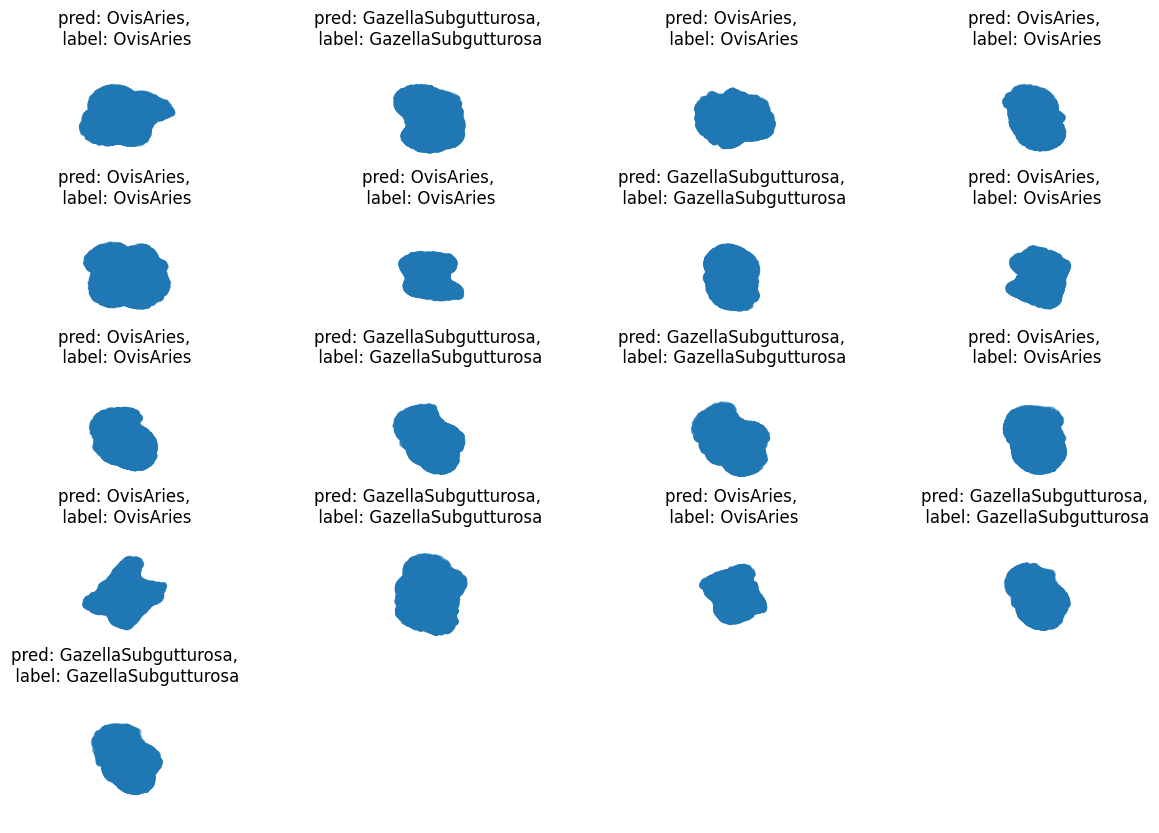

In [17]:
# Visualize the predictions
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:17, ...]
labels = labels [:17, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class
fig = plt.figure(figsize=(15,10))
for i in range(17):
    ax = fig.add_subplot(5, 4, i+1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title("pred: {:},\n label: {:}".format(CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]))
    ax.set_axis_off()
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

y_test = labels.numpy()
y_pred = preds.numpy()

print("\nBalanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))


Balanced Accuracy: 1.0

Confusion matrix:
 [[ 7  0]
 [ 0 10]]

Report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         7
           1      1.000     1.000     1.000        10

    accuracy                          1.000        17
   macro avg      1.000     1.000     1.000        17
weighted avg      1.000     1.000     1.000        17

